In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

In [4]:
!pip install --upgrade jax jaxlib diffrax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.3/84.3 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
  Attempting uninstall: diffrax
    Found existing installation: diffrax 0.4.1
    Uninstalling diffrax-0.4.1:
      Successfully uninstalled diffrax-0.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


# Homework 2

## References

+ Module 3: Uncertainty Propagation Through Scientific Models
   - Local sensitivity analysis
   - Global sensitivity analysis

## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

## Student details

+ **First Name:**Yikai
+ **Last Name:**Liu
+ **Email:**liu3307@purdue.edu
+ **Used generative AI to complete this assignment (Yes/No):**No
+ **Which generative AI tool did you use (if applicable)?:**

## Problem 1 - Local sensitivity analysis of nonlinear dynamical system

Consider the Duffing oscillator:

$$\ddot{x} + \delta \dot{x} + \alpha x + \beta x^3 = \gamma \cos(\omega t)$$

where $\delta$, $\alpha$, $\beta$, $\gamma$, and $\omega$ are constants. As a system of first order equations, introducing $v = \dot{x}$, we have:

$$\begin{align}
\dot{x} & = v \\
\dot{v} & = \gamma \cos(\omega t) - \delta v - \alpha x - \beta x^3
\end{align}$$

The initial conditions are $x(0) = x_0$ and $v(0) = v_0$.
Denote by $\theta$ the **vector of all parameters and initial conditions**, i.e. $\theta = (x_0, v_0, \alpha, \beta, \gamma, \delta, \omega)$.
The vector field $f(x,v,t;\theta)$ is then given by:

$$f(x,v,t;\theta) = \begin{pmatrix}
v \\
\gamma \cos(\omega t) - \delta v - \alpha x - \beta x^3
\end{pmatrix}.$$

### Part A: Implement the Duffing oscillator
Modify the code of [this example](https://predictivesciencelab.github.io/advanced-scientific-machine-learning/up/sensitivity_analysis/03_example_ode.html) to create a solver that takes $\theta$ as an input and returns the solution of the Duffing oscillator for a given the interval of time $[0, 30]$ with a time step of 0.1.
Make sure your code can be vectorized with respect to $\theta$ and that it can be `jit`ed.

**Answer:**

In [4]:
import jax
import jax.numpy as jnp
from diffrax import diffeqsolve, Tsit5, ODETerm, SaveAt
def duffing_vector_field(t, y, theta):
    alpha = theta[2]
    beta  = theta[3]
    gamma = theta[4]
    delta = theta[5]
    omega = theta[6]
    x, v = y
    return jnp.array([
        v,
        gamma * jnp.cos(omega * t) - delta * v - alpha * x - beta * x**3
    ])
def solve_duffing(theta):
    y0 = jnp.array([theta[0], theta[1]])
    term = ODETerm(duffing_vector_field)
    solver = Tsit5()
    saveat = SaveAt(ts=jnp.linspace(0, 30, int(30 / 0.1) + 1))
    sol = diffeqsolve(
        term,
        solver,
        t0=0,
        t1=30,
        dt0=0.1,
        y0=y0,
        args=theta,
        saveat=saveat
    )
    return sol.ys
solve_duffing_jit = jax.jit(solve_duffing)
theta_example = jnp.array([1.0, 0.0, 1.0, 5.0, 0.37, 0.1, 1.0])
solution_example = solve_duffing_jit(theta_example)
print("Solution for theta_example (shape {}):".format(solution_example.shape))
print(solution_example)
theta_batch = jnp.array([
    [1.0, 0.0, 1.0, 5.0, 0.37, 0.1, 1.0],
    [1.0, 0.5, 1.0, 5.0, 0.37, 0.1, 1.0]
])
solutions_batch = jax.vmap(solve_duffing_jit)(theta_batch)
print("\nBatch solution shape:", solutions_batch.shape)


Solution for theta_example (shape (301, 2)):
[[ 1.          0.        ]
 [ 0.97231    -0.5456661 ]
 [ 0.8937249  -1.0068084 ]
 [ 0.7753365  -1.3378291 ]
 [ 0.6306263  -1.5358499 ]
 [ 0.4717166  -1.6276606 ]
 [ 0.30741644 -1.6495922 ]
 [ 0.14307861 -1.6326897 ]
 [-0.0184766  -1.5959942 ]
 [-0.1756686  -1.5453525 ]
 [-0.32689425 -1.4748213 ]
 [-0.46947733 -1.3694648 ]
 [-0.5989785  -1.2099242 ]
 [-0.7090876  -0.9795409 ]
 [-0.79233986 -0.6734283 ]
 [-0.84170574 -0.3059989 ]
 [-0.85262537  0.08848485]
 [-0.8246056   0.4652378 ]
 [-0.76152354  0.7842276 ]
 [-0.6704732   1.0225354 ]
 [-0.55981207  1.1774855 ]
 [-0.4373544   1.2612822 ]
 [-0.3093092   1.2924298 ]
 [-0.18002999  1.2885644 ]
 [-0.05233183  1.2624176 ]
 [ 0.07193353  1.2204695 ]
 [ 0.1912583   1.1632437 ]
 [ 0.30393526  1.0865053 ]
 [ 0.40767133  0.98311514]
 [ 0.4994167   0.84556746]
 [ 0.57548124  0.6691108 ]
 [ 0.63196933  0.45483455]
 [ 0.66547275  0.2115449 ]
 [ 0.6738375  -0.04483801]
 [ 0.6567245  -0.29468772]
 [ 0.61573

### Part B: Plot the strange attractor

Fix the values of the parameters to: $\alpha = 1$, $\beta = 5, \gamma = 8, \delta = 0.02$, and $\omega = 0.5$. Use the solver you implemented in Part A to plot the [strange attractor](https://en.wikipedia.org/wiki/Attractor#Strange_attractor) of the Duffing oscillator. To do this, just sample the initial conditions $x_0$ and $v_0$ from a uniform distribution in the interval $[-1, 1]$ and do the scatter plot of the points $(x(t), v(t))$ at $t = 50$. It looks like [this](https://en.wikipedia.org/wiki/Duffing_equation#/media/File:Forced_Duffing_equation_Poincaré_section.png).

Hint: Just make a 2D array of $\theta$'s with the first two columns randomly sampled and the rest fixed. Then pass the samples through your vectorized and `jit`ed solver and plot the results.

**Answer:**

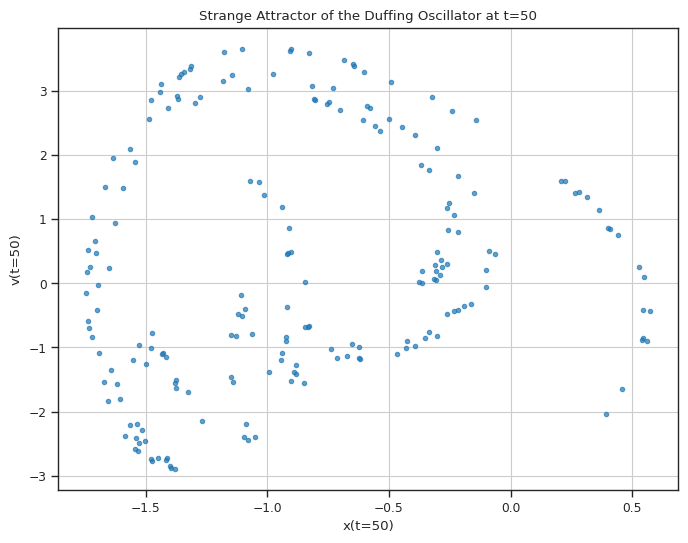

In [6]:
solve_duffing_jit = jax.jit(solve_duffing)
num_sims = 200
rng_key = jax.random.PRNGKey(42)
rng_key, subkey1, subkey2 = jax.random.split(rng_key, 3)
x0_samples = jax.random.uniform(subkey1, (num_sims,), minval=-1.0, maxval=1.0)
v0_samples = jax.random.uniform(subkey2, (num_sims,), minval=-1.0, maxval=1.0)
alpha = 1.0
beta  = 5.0
gamma = 8.0
delta = 0.02
omega = 0.5
theta_batch = jnp.column_stack([
    x0_samples,
    v0_samples,
    jnp.full((num_sims,), alpha),
    jnp.full((num_sims,), beta),
    jnp.full((num_sims,), gamma),
    jnp.full((num_sims,), delta),
    jnp.full((num_sims,), omega)
])
solutions_batch = jax.vmap(solve_duffing_jit)(theta_batch)
final_points = solutions_batch[:, -1, :]
plt.figure(figsize=(8, 6))
plt.scatter(final_points[:, 0], final_points[:, 1], s=10, alpha=0.7)
plt.xlabel("x(t=50)")
plt.ylabel("v(t=50)")
plt.title("Strange Attractor of the Duffing Oscillator at t=50")
plt.grid(True)
plt.show()

### Part C: Local sensitivity analysis

Suppose you have a 1\% uncertainty about $\alpha, \beta, \delta, \gamma, \omega$ and 5\% uncertainty about the initial conditions $x_0$ and $v_0$. You can model this uncertainty with the Gaussian random variable:

$$
\theta \sim \mathcal{N}\left(
\begin{pmatrix}
0.5\\
0.5\\
1 \\
5 \\
0.37 \\
0.1 \\
1
\end{pmatrix},
\begin{pmatrix}
0.025^2 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0.025^2 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0.01^2 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0.05^2 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0.0037^2 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0.001^2 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0.01^2
\end{pmatrix}
\right)
$$

+ Use local sensitivity analysis to propagate this uncertainty through the Duffing oscillator.
+ Use your results to plot 95\% credible intervals of $x(t)$ and $v(t)$ as functions of time for $t \in [0, 10]$.
+ Plot the estimated mean and variance of $x(t)$ and $v(t)$ as functions of time for $t \in [0, 30]$ and compare to Monte Carlo estimates using $10^5$ samples. For how long does the local sensitivity analysis give a good approximation of the mean and variance?

**Answer:**

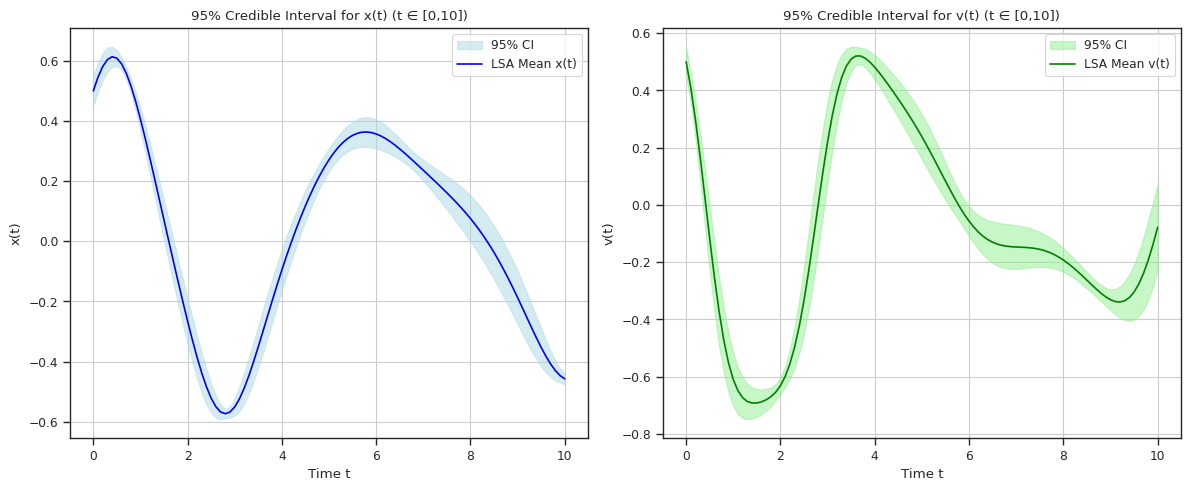

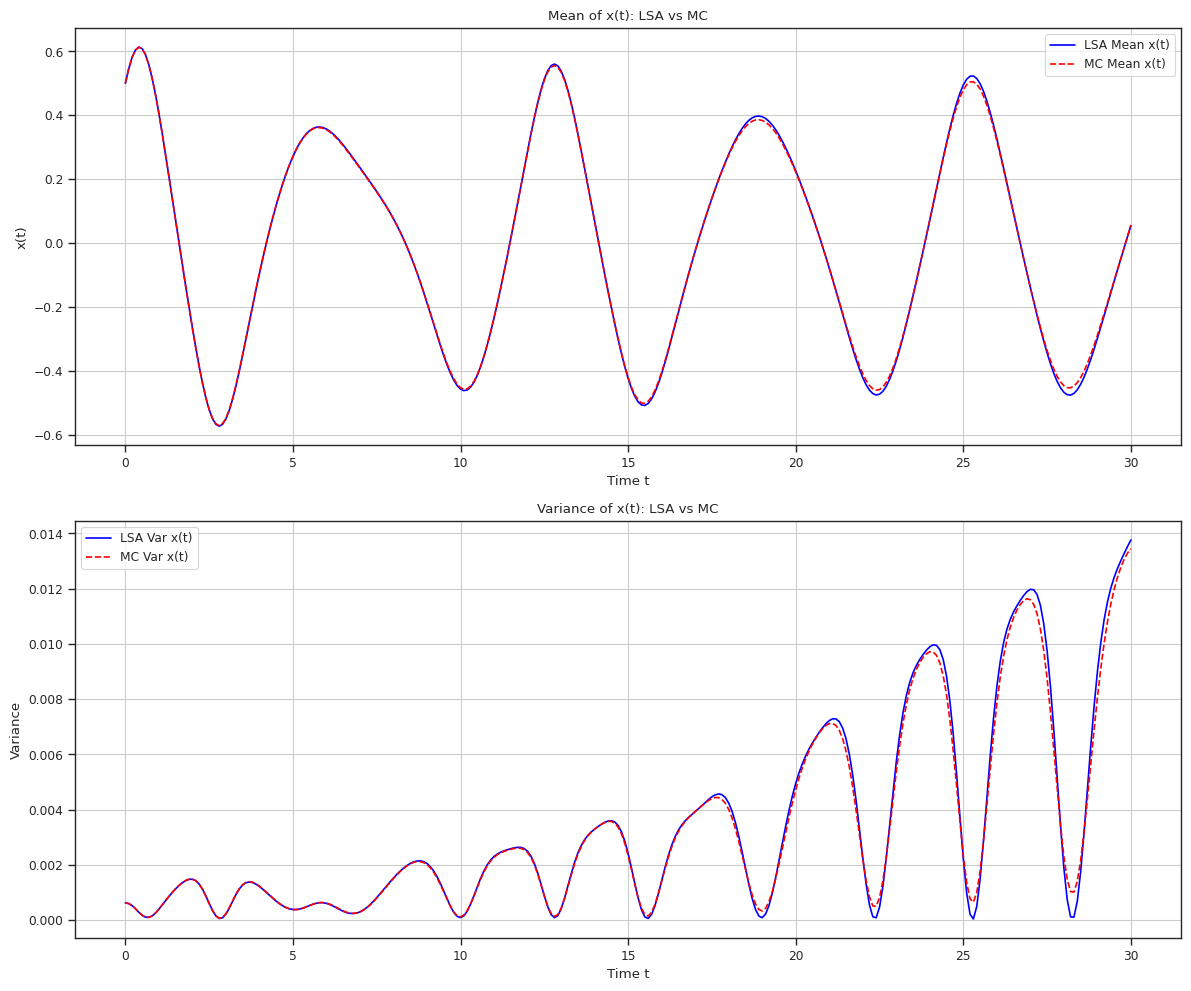

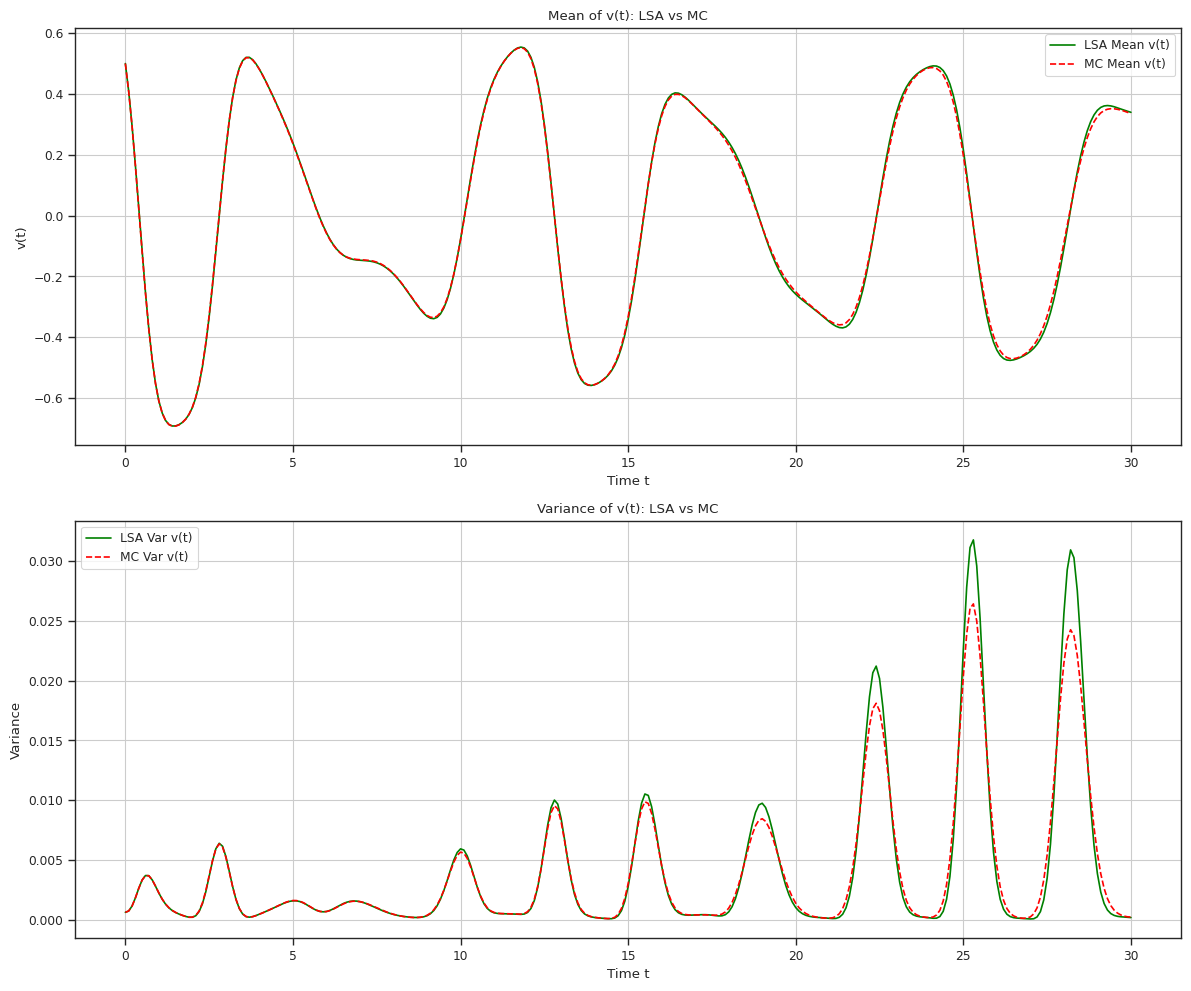

In [8]:
solve_duffing_jit = jax.jit(solve_duffing)
theta0 = jnp.array([0.5, 0.5, 1.0, 5.0, 0.37, 0.1, 1.0])
t_points = jnp.linspace(0, 30, int(30/0.1)+1)
y_nom = solve_duffing_jit(theta0)
jac_y = jax.jacrev(solve_duffing_jit)(theta0)

stds = jnp.array([0.025, 0.025, 0.01, 0.05, 0.0037, 0.001, 0.01])
Sigma_theta = jnp.diag(stds**2)

def compute_cov(jac_t):
    return jac_t @ Sigma_theta @ jac_t.T

cov_y = jax.vmap(compute_cov)(jac_y)


t_limit = 10
n_limit = int(t_limit/0.1) + 1
t_points_10 = t_points[:n_limit]
y_nom_10 = y_nom[:n_limit]
cov_y_10 = cov_y[:n_limit]


ci_x_lower = y_nom_10[:,0] - 1.96 * jnp.sqrt(cov_y_10[:,0,0])
ci_x_upper = y_nom_10[:,0] + 1.96 * jnp.sqrt(cov_y_10[:,0,0])
ci_v_lower = y_nom_10[:,1] - 1.96 * jnp.sqrt(cov_y_10[:,1,1])
ci_v_upper = y_nom_10[:,1] + 1.96 * jnp.sqrt(cov_y_10[:,1,1])


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.fill_between(t_points_10, ci_x_lower, ci_x_upper, color='lightblue', alpha=0.5, label='95% CI')
plt.plot(t_points_10, y_nom_10[:,0], 'b-', label='LSA Mean x(t)')
plt.xlabel('Time t')
plt.ylabel('x(t)')
plt.title('95% Credible Interval for x(t) (t ∈ [0,10])')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.fill_between(t_points_10, ci_v_lower, ci_v_upper, color='lightgreen', alpha=0.5, label='95% CI')
plt.plot(t_points_10, y_nom_10[:,1], 'g-', label='LSA Mean v(t)')
plt.xlabel('Time t')
plt.ylabel('v(t)')
plt.title('95% Credible Interval for v(t) (t ∈ [0,10])')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

N_mc = 10**5
key = jax.random.PRNGKey(0)
theta_samples = theta0 + stds * jax.random.normal(key, (N_mc, 7))
solutions_mc = jax.vmap(solve_duffing_jit)(theta_samples)
mean_mc = jnp.mean(solutions_mc, axis=0)  #
var_mc = jnp.var(solutions_mc, axis=0)


var_lsa = jnp.stack([cov_y[:,0,0], cov_y[:,1,1]], axis=-1)


plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(t_points, y_nom[:,0], 'b-', label='LSA Mean x(t)')
plt.plot(t_points, mean_mc[:,0], 'r--', label='MC Mean x(t)')
plt.xlabel('Time t')
plt.ylabel('x(t)')
plt.title('Mean of x(t): LSA vs MC')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(t_points, var_lsa[:,0], 'b-', label='LSA Var x(t)')
plt.plot(t_points, var_mc[:,0], 'r--', label='MC Var x(t)')
plt.xlabel('Time t')
plt.ylabel('Variance')
plt.title('Variance of x(t): LSA vs MC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.plot(t_points, y_nom[:,1], 'g-', label='LSA Mean v(t)')
plt.plot(t_points, mean_mc[:,1], 'r--', label='MC Mean v(t)')
plt.xlabel('Time t')
plt.ylabel('v(t)')
plt.title('Mean of v(t): LSA vs MC')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(t_points, var_lsa[:,1], 'g-', label='LSA Var v(t)')
plt.plot(t_points, var_mc[:,1], 'r--', label='MC Var v(t)')
plt.xlabel('Time t')
plt.ylabel('Variance')
plt.title('Variance of v(t): LSA vs MC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Part D: Local sensitivity analysis results in a Gaussian process approximation of the uncertain dynamical system

As we discussed in the [theory](https://predictivesciencelab.github.io/advanced-scientific-machine-learning/up/sensitivity_analysis/01_theory.html), local sensitivity analysis results in a (vector-valued) Gaussian process.

+ Plot the covariance of $x(t)$ with $x(0)$, i.e., plot the function:

    $$
    g(t) = \text{Cov}[x(t), x(0)] = \nabla_\theta x(t)\Sigma \nabla_\theta x(0)^\top,
    $$

    for $t$ in $[0, 5]$.
    (Recall $x$ is the *position* of the oscillator.)

+ Take five (5) samples from the Gaussian process corresponding to $x(t)$ and plot them as functions of time for $t \in [0, 5]$. Hint: The mean is just the local sensitivity analysis estimate of the mean. Then you will have to find the covariance matrix of $x(t_i)$, for $t_i$ points in $[0,5]$, and sample from the corresponding multivariate Gaussian distribution.
(And don't forget to add some jitter to the diagonal of the covariance matrix for numerical stability.)

**Answer:**

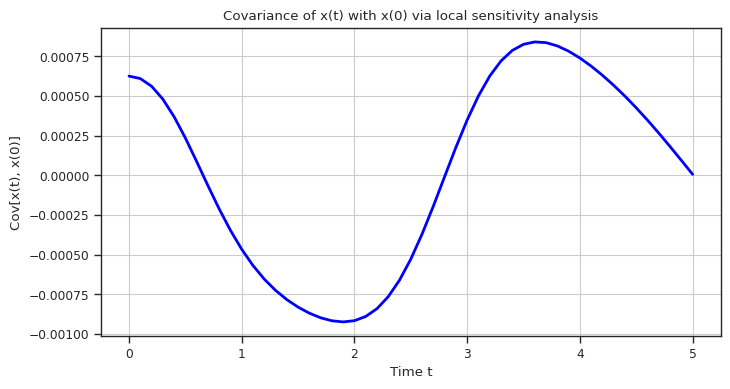

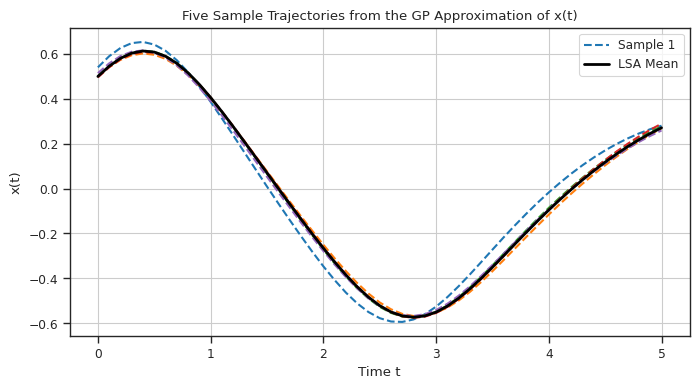

In [10]:
def solve_duffing(theta):
    y0 = jnp.array([theta[0], theta[1]])
    term = ODETerm(duffing_vector_field)
    solver = Tsit5()
    t_points = jnp.linspace(0, 5, 51)
    saveat = SaveAt(ts=t_points)
    sol = diffeqsolve(term, solver, t0=0, t1=5, dt0=0.1, y0=y0, args=theta, saveat=saveat)
    return sol.ys
solve_duffing_jit = jax.jit(solve_duffing)
theta0 = jnp.array([0.5, 0.5, 1.0, 5.0, 0.37, 0.1, 1.0])
stds   = jnp.array([0.025, 0.025, 0.01, 0.05, 0.0037, 0.001, 0.01])
Sigma  = jnp.diag(stds**2)

jac_full = jax.jacrev(solve_duffing_jit)(theta0)
grad_x = jac_full[:, 0, :]
grad_x0 = grad_x[0, :]
g_t = jnp.dot(grad_x, Sigma @ grad_x0)
t_points = jnp.linspace(0, 5, 51)
plt.figure(figsize=(8, 4))
plt.plot(t_points, g_t, 'b-', lw=2)
plt.xlabel("Time t")
plt.ylabel("Cov[x(t), x(0)]")
plt.title("Covariance of x(t) with x(0) via local sensitivity analysis")
plt.grid(True)
plt.show()
sol_nom = solve_duffing_jit(theta0)
mean_x = sol_nom[:, 0]
K = grad_x @ Sigma @ grad_x.T
jitter = 1e-8
K_jitter = K + jitter * jnp.eye(K.shape[0])
L = jnp.linalg.cholesky(K_jitter)
key = jax.random.PRNGKey(0)
z = jax.random.normal(key, (5, K.shape[0]))
samples = mean_x + (L @ z.T).T

plt.figure(figsize=(8, 4))
for i in range(5):
    plt.plot(t_points, samples[i, :], lw=1.5, ls='--', label=f"Sample {i+1}" if i==0 else None)
plt.plot(t_points, mean_x, 'k-', lw=2, label="LSA Mean")
plt.xlabel("Time t")
plt.ylabel("x(t)")
plt.title("Five Sample Trajectories from the GP Approximation of x(t)")
plt.legend()
plt.grid(True)
plt.show()

### Part E: Global sensitivity analysis

Sobol sensitivity indices are a popular way to quantify the importance of the parameters of a model.
The caveat is that they assume that the inputs of the model are independent and uniformly distributed.
So, before applying the method, we will have to transform the random variables $\theta_i$ to uniform random variables $\xi_i$.

+ Find random variables $\xi_i$ and transformation functions $F_i$, such that $\xi_i \sim U(0, 1)$ and $\theta_i = F_i^{-1}(\xi_i)$. Explicitly write down what what are these transformation functions. Hint: Recall that if $X$ is a random variable with CDF $F_X$, then $Y = F_X(X)$ is a random variable with uniform distribution in $[0, 1]$.
+ Implement a solver that takes $\xi$ as an input and returns the solution of the Duffing oscillator for a given the interval of time $[0, 30]$ with a time step of 0.1.
+ Compute the first order Sobol sensitivity indices for the Duffing oscillator using the solver you just implemented. Make sure you have used enough samples to get a convergent estimate of the Sobol indices. You can use the [SALib](https://salib.readthedocs.io/en/latest/) library to do this.

**Answer:**

In [13]:
import jax
import jax.numpy as jnp
import jax.scipy.special as jsp
import numpy as np
from diffrax import diffeqsolve, Tsit5, ODETerm, SaveAt
def theta_from_xi(xi):
    mu = jnp.array([0.5, 0.5, 1.0, 5.0, 0.37, 0.1, 1.0])
    sigma = jnp.array([0.025, 0.025, 0.01, 0.05, 0.0037, 0.001, 0.01])
    return mu + sigma * jsp.ndtri(xi)

def duffing_vector_field(t, y, theta):
    alpha = theta[2]
    beta  = theta[3]
    gamma = theta[4]
    delta = theta[5]
    omega = theta[6]
    x, v = y
    return jnp.array([v, gamma * jnp.cos(omega * t) - delta*v - alpha*x - beta*x**3])

def solve_duffing(theta):
    y0 = jnp.array([theta[0], theta[1]])
    term = ODETerm(duffing_vector_field)
    solver = Tsit5()
    t_points = jnp.linspace(0, 30, int(30/0.1) + 1)
    saveat = SaveAt(ts=t_points)
    sol = diffeqsolve(term, solver, t0=0, t1=30, dt0=0.1, y0=y0, args=theta, saveat=saveat)
    return sol.ys
solve_duffing_jit = jax.jit(solve_duffing)
def solve_duffing_from_xi(xi):
    theta = theta_from_xi(jnp.array(xi))
    return solve_duffing_jit(theta)
def model(xi):
    sol = solve_duffing_from_xi(xi)
    return sol[-1, 0]  # x(t=30)
problem = {
    'num_vars': 7,
    'names': ['x0', 'v0', 'alpha', 'beta', 'gamma', 'delta', 'omega'],
    'bounds': [[0, 1]] * 7
}

from SALib.sample import saltelli
from SALib.analyze import sobol
N = 1000
param_values = saltelli.sample(problem, N)
Y = np.array([float(model(xi)) for xi in param_values])
Si = sobol.analyze(problem, Y, print_to_console=True)


<ipython-input-13-26653b2ce110>:98: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, N)
/usr/local/lib/python3.11/dist-packages/SALib/sample/saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


             ST   ST_conf
x0     0.000294  0.000039
v0     0.000692  0.000072
alpha  0.000025  0.000004
beta   0.000462  0.000058
gamma  0.001588  0.000181
delta  0.000107  0.000012
omega  0.997645  0.053527
             S1   S1_conf
x0     0.000332  0.001290
v0     0.000690  0.002437
alpha -0.000041  0.000469
beta   0.000437  0.001765
gamma  0.001579  0.003834
delta  0.000151  0.000916
omega  0.998044  0.080433
                      S2   S2_conf
(x0, v0)        0.000123  0.001933
(x0, alpha)     0.000124  0.001938
(x0, beta)      0.000135  0.001932
(x0, gamma)     0.000188  0.001956
(x0, delta)     0.000116  0.001944
(x0, omega)     0.000152  0.002524
(v0, alpha)     0.000077  0.003123
(v0, beta)      0.000078  0.003119
(v0, gamma)     0.000066  0.003132
(v0, delta)     0.000073  0.003123
(v0, omega)     0.000029  0.004812
(alpha, beta)   0.000079  0.000803
(alpha, gamma)  0.000063  0.000811
(alpha, delta)  0.000076  0.000808
(alpha, omega)  0.000133  0.000920
(beta, gamma)  -0.000028

In [12]:
!pip install SALib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.9 MB/s eta 0:00:00
